In [30]:
from __future__ import print_function
import gc
import os
import sys
import math
import time
import scipy.stats as ss
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from models.PCConvNet import PCConvNet, PCConvNetCls
from models.PCConvLstmNet import PCConvLstmNet, PCConvLstmNetCls
from dataLoaders.PitchContourDataset import PitchContourDataset
from dataLoaders.PitchContourDataloader import PitchContourDataloader
from dataLoaders.MASTDataset import MASTDataset
from dataLoaders.MASTDataloader import MASTDataloader
from tensorboard_logger import configure, log_value
from sklearn import metrics
import eval_utils
import train_utils
import dill
import matplotlib.pyplot as plot
from sklearn.manifold import TSNE
import seaborn as sns
from contrastive_utils import ContrastiveLoss
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
sns.set(rc={'figure.figsize':(11.7,8.27)})
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# initialize training parameters
RUN = 110
NUM_EPOCHS = 300 #250 #2000
NUM_BATCHES = 10
SEGMENT = '2'
MTYPE = 'conv'
CTYPE = 0
# initialize dataset, dataloader and created batched data

#SET CONSTANTS
metric_type = {0:'musicality', 1:'note accuracy',2:'Rhythm Accuracy',3:'tonality'}
instrument = 'clarinet'
cross_instrument = 'clarinet'
experiment = 'redo-init_euclid-binary'
best = True
METRIC = 0 # 0: Musicality, 1: Note Accuracy, 2: Rhythmic Accuracy, 3: Tone Quality
BAND = 'middle'
ADD_NOISE_TEST = False
ADD_NOISE_VALID = False
NOISE_SHAPE = 'triangular'  #triangular, normal, or uniform
INPUT_REP = 'Cepstrum'
NAME = '{0}_{1}_{2}_{3}_{4}'.format(BAND, instrument, metric_type[METRIC], INPUT_REP, experiment)

#SET TRAINING CONSTANTS
contrastive = True
MSE_LOSS_STR = 0.4
CONTR_LOSS_STR = 0.8
if contrastive:
    c_loss = ContrastiveLoss(num_labels=4)

In [45]:
datasets = {'flute':{'test':'/media/SSD/FBA/crossInstr/middle_Flute__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Flute__train_fixed.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Flute__valid.dill'},
            'clarinet':{'test':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__train.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet__valid.dill'},
            'saxophone':{'test':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__test.dill', 'train':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__train.dill', 'valid':'/media/SSD/FBA/crossInstr/middle_Alto Saxophone__valid.dill'}}
datasets_all = {'flute': '/media/SSD/FBA/crossInstr/middle_Flute_.dill', 'saxophone': '/media/SSD/FBA/crossInstr/middle_Alto Saxophone_.dill', 'clarinet':'/media/SSD/FBA/crossInstr/middle_Bb Clarinet_.dill', 
                'ALL':'/media/SSD/FBA/saved_dill/middle_2_new_dataPC.dill'}
file_name = BAND + '_' + str(SEGMENT) + '_data'
with open(datasets_all[cross_instrument], 'rb') as f:
    NUM_DATA_POINTS = len(dill.load(f))
if sys.version_info[0] < 3:
    data_path = 'dat/' + file_name + '.dill'
    mast_path = '/Users/Som/GitHub/Mastmelody_dataset/f0data'
else:
    if torch.cuda.is_available():
        data_path = '/home/data_share/FBA/fall19/data/pitch_contour/' + BAND + '_2_pc_3.dill'
    else:
        data_path = '/Volumes/Farren/python_stuff/dat/' + BAND + '_2_data_3.dill'

    mast_path = '/home/apati/MASTmelody_dataset/f0data'

if BAND == 'mast':
    dataset = MASTDataset(mast_path)
    dataloader = MASTDataloader(dataset)
    CTYPE = 1
else:
    dataset = PitchContourDataset(datasets_all[cross_instrument])
    dataloader = PitchContourDataloader(dataset, NUM_DATA_POINTS, NUM_BATCHES)


tr1, v1, vef, te1, tef = dataloader.create_split_data(1000, 500) #1000, 500 | 1500, 500 | 2000, 1000
tr2, v2, _, te2, _ = dataloader.create_split_data(1500, 500)
tr3, v3, _, te3, _ = dataloader.create_split_data(2000, 1000)
#tr4, v4, _, te4, _ = dataloader.create_split_data(2500, 1000)
#tr5, v5, _, te5, _ = dataloader.create_split_data(3000, 1500)
#tr6, v6, vef, te6, tef = dataloader.create_split_data(4000, 2000)
training_data = tr1 + tr2 + tr3 #+ tr2 + tr3 #+ tr4 + tr5 + tr6     # this is the proper training data split
validation_data = vef #+ v2 + v3 + v4 + v5 + v6
testing_data = te1 + te2 + te3 #+ te4 + te5 + te6


## augment data
aug_training_data = train_utils.augment_data(training_data)
aug_training_data = train_utils.augment_data(aug_training_data)
aug_validation_data = validation_data  #train_utils.augment_data(validation_data)


## initialize model
if MTYPE == 'conv':
    if BAND == 'mast':
        perf_model = PCConvNetCls(1)
    else:
        perf_model = PCConvNet(0)
elif MTYPE == 'lstm':
    if BAND == 'mast':
        perf_model = PCConvLstmNetCls()
    else:
        perf_model = PCConvLstmNet()        
if torch.cuda.is_available():
    perf_model.cuda()
if BAND == 'mast':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MSELoss()


# test
# test of full length data
#test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
#print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Testing Loss: ', test_loss, ' R-sq: ', test_r_sq, ' Accu:', test_accu, test_accu2))

# validate and test on best validation model
# read the model
#filename = file_info + '_Reg'

927
{'year': '2013', 'band': 'middleschool', 'instrumemt': 'Bb Clarinet', 'student_id': 28600, 'segment': 2, 'audio': (array([0.00584585, 0.0083638 , 0.00723331, ..., 0.00264784, 0.00218224,
       0.00240789], dtype=float32), 22050), 'pitch_contour': array([0., 0., 0., ..., 0., 0., 0.]), 'ratings': (0.85, 0.8, 0.7, 0.87), 'class_ratings': [8.0, 8.0, 7.0, 9.0], 'length': 3648}


In [46]:
filename = NAME + '_best' if best else NAME #if instrument == 'saxophone' else NAME + '_best'
if torch.cuda.is_available():
    perf_model.cuda()
    #perf_model.load_state_dict(torch.load('/Users/michaelfarren/Desktop/MusicPerfAssessment-master/src/runs/' + filename + '.pt'))
    perf_model.load_state_dict(torch.load('pc_contrastive_runs/' + filename))

else:
    perf_model.load_state_dict(torch.load('pc_contrastive_runs/' + filename + '.pt', map_location=lambda storage, loc: storage))

print(len(aug_training_data))
preds, targets = eval_utils.eval_model_preds(perf_model, criterion, vef, METRIC, MTYPE, CTYPE, latent=True)

val_loss, val_r_sq, val_accu, val_accu2 = eval_utils.eval_model(perf_model, criterion, vef, METRIC, MTYPE, CTYPE)
print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Valid Loss: ', val_loss, ' R-sq: ', val_r_sq, ' Accu:', val_accu, val_accu2))

test_loss, test_r_sq, test_accu, test_accu2 = eval_utils.eval_model(perf_model, criterion, testing_data, METRIC, MTYPE, CTYPE)
print('[%s %0.5f, %s %0.5f, %s %0.5f %0.5f]'% ('Testing Loss: ', test_loss, ' R-sq: ', test_r_sq, ' Accu:', test_accu, test_accu2))

120
[Valid Loss:  0.02462,  R-sq:  0.67291,  Accu: 0.16304 0.77174]
[Testing Loss:  0.04427,  R-sq:  0.32350,  Accu: 0.15679 0.74933]


In [47]:
#toggle interactive plots
#%matplotlib notebook

In [51]:
#TSNE CLUSTERING OF PREDICTIONS
#print(targets.T.flatten())
c_loss = ContrastiveLoss(num_labels=2)
print(preds)
#y = c_loss.label_map(preds).cpu()
#print(preds)
viz = 0 #0 for tsne, 1 for pca
components = 3
print(preds.size(), targets.size())
y = c_loss.label_map(targets.T.flatten())

if viz == 0:
    tsne = TSNE(n_components=2, perplexity=5, learning_rate=50.0, metric='euclidean', init='pca')
    latent = preds.cpu()
    y_embed = tsne.fit_transform(latent)
    
print(latent.size())
palette = sns.color_palette("bright", len(np.unique(y)))
cmap = ListedColormap(palette.as_hex())

tensor([[0.3620, 0.2910, 0.3527,  ..., 0.2256, 0.1854, 0.2557],
        [0.2823, 0.1821, 0.5035,  ..., 0.1965, 0.3246, 0.3427],
        [0.2461, 0.1908, 0.4306,  ..., 0.2171, 0.3880, 0.3047],
        ...,
        [0.2286, 0.2096, 0.4184,  ..., 0.2400, 0.3783, 0.3113],
        [0.2393, 0.3210, 0.3497,  ..., 0.3071, 0.4827, 0.3213],
        [0.2684, 0.3531, 0.4131,  ..., 0.2759, 0.4979, 0.4795]],
       device='cuda:0')
torch.Size([92, 16]) torch.Size([92, 1])
torch.Size([92, 16])


In [52]:
dist = c_loss.euclid(preds[:-1, :], preds[1:,:])
print(dist.size(), preds.size(), dist)
dist = c_loss.cosine_sim(preds[:-1, :], preds[1:,:])
print(dist.size(), preds.size(), dist)

torch.Size([91]) torch.Size([92, 16]) tensor([0.6067, 0.1368, 0.1107, 0.2279, 0.2137, 0.5149, 0.3234, 0.2171, 0.2130,
        0.2558, 0.2438, 0.2624, 0.3199, 0.1351, 0.4621, 0.3386, 0.1054, 0.4014,
        0.5119, 0.2924, 0.4600, 0.3316, 0.2341, 0.3956, 0.2144, 0.3004, 0.2781,
        0.4458, 0.4677, 0.2400, 0.3685, 0.4009, 0.3168, 0.2742, 0.2715, 0.2738,
        0.3105, 0.3836, 0.3982, 0.3142, 0.2400, 0.6096, 0.5599, 0.2193, 0.3590,
        0.2770, 0.3346, 0.4663, 0.5476, 0.3045, 0.1888, 0.2262, 0.4721, 0.4978,
        0.3521, 0.3565, 0.2333, 0.3558, 1.5447, 1.5430, 0.3174, 0.2465, 0.2871,
        0.3652, 0.4344, 0.5337, 0.2626, 0.3610, 0.4652, 0.2177, 0.3062, 0.2746,
        0.3943, 0.3739, 1.1879, 1.4311, 0.1732, 0.4222, 0.2969, 0.1425, 0.2075,
        0.3219, 0.1886, 0.1738, 0.2257, 0.7423, 0.6622, 0.5203, 0.4262, 0.2586,
        0.3148], device='cuda:0')
torch.Size([91]) torch.Size([92, 16]) tensor([0.9143, 0.9962, 0.9973, 0.9865, 0.9893, 0.9528, 0.9863, 0.9893, 0.9924,
        0.

Text(0.5, 1.0, 'musicality')

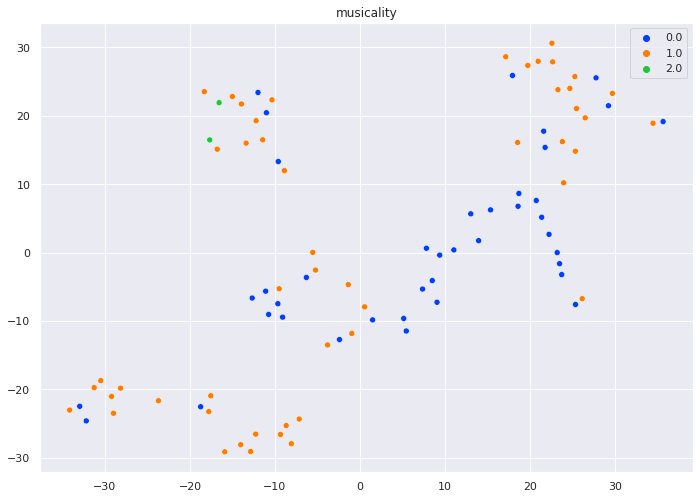

In [53]:
sns.scatterplot(x=y_embed[:,0], y=y_embed[:,1], hue=y, legend='full', palette=palette).set_title(metric_type[METRIC])

<IPython.core.display.Javascript object>


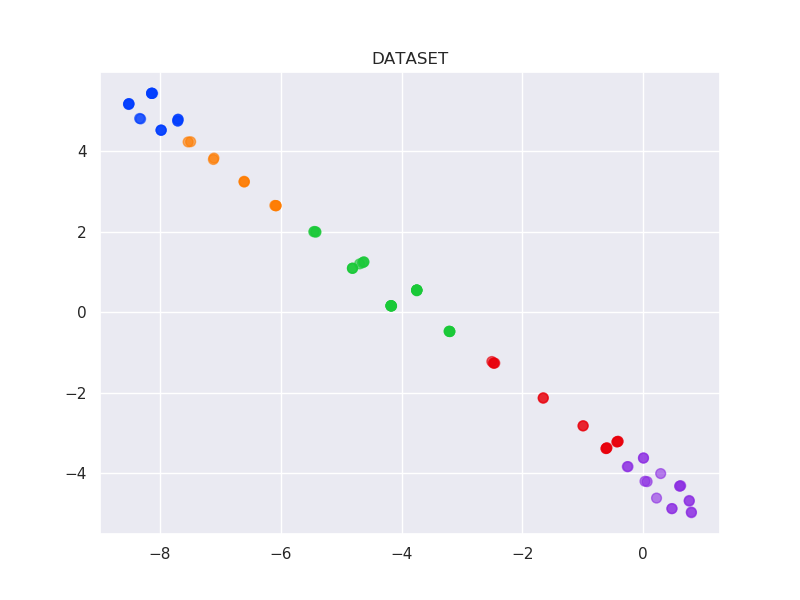

In [221]:
sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=y, legend='full', palette=palette).set_title('DATASET')
if x_embed.shape[1] == 2:
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.scatter(x_embed[:,0], x_embed[:,1], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('DATASET')
elif x_embed.shape[1] == 3:
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_embed[:,0], x_embed[:,1], x_embed[:,2], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('DATASET')

<IPython.core.display.Javascript object>


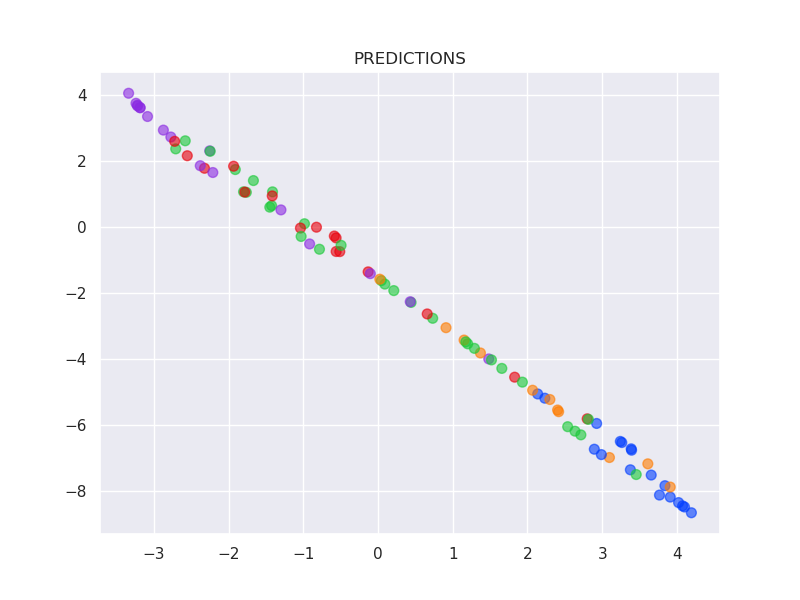

In [226]:
if y_embed.shape[1] == 2:
    #sns.scatterplot(x=y_embed[:,0], y=y_embed[:,1], hue=y, legend='full', palette=palette).set_title('PREDICTIONS')
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.scatter(y_embed[:,0], y_embed[:,1], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('PREDICTIONS')
if y_embed.shape[1] == 3:
    fig = plot.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y_embed[:,0], y_embed[:,1], y_embed[:,2], s=50, alpha=0.6, cmap=cmap, c=y)
    ax.set_title('PREDICTIONS')